# Ignition Delay with Custom Code (Constant Pressure Reactor)

Code is ported (almost) verbatim from cantera example file `custom.py` (distributed with cantera):
```
"""
Solve a constant pressure ignition problem where the governing equations are
implemented in Python.

This demonstrates an approach for solving problems where Cantera's reactor
network model cannot be configured to describe the system in question. Here,
Cantera is used for evaluating thermodynamic properties and kinetic rates while
an external ODE solver is used to integrate the resulting equations. In this
case, the SciPy wrapper for VODE is used, which uses the same variable-order BDF
methods as the Sundials CVODES solver used by Cantera.
"""
```

In [1]:
import cantera as ct
import numpy as np
import scipy.integrate

import matplotlib.pyplot as plt
%matplotlib notebook

### Custom Code

In [2]:
class ReactorOde(object):
    def __init__(self, gas):
        # Parameters of the ODE system and auxiliary data are stored in the
        # ReactorOde object.
        self.gas = gas
        self.P = gas.P

    def __call__(self, t, y):
        """the ODE function, y' = f(t,y) """

        # State vector is [T, Y_1, Y_2, ... Y_K]
        self.gas.set_unnormalized_mass_fractions(y[1:])
        self.gas.TP = y[0], self.P
        rho = self.gas.density

        wdot = self.gas.net_production_rates
        dTdt = - (np.dot(self.gas.partial_molar_enthalpies, wdot) /
                  (rho * self.gas.cp))
        dYdt = wdot * self.gas.molecular_weights / rho

        return np.hstack((dTdt, dYdt))

### Problem Setup

In [3]:
gas = ct.Solution('gri30.xml')

# Initial condition
P = ct.one_atm
gas.TPX = 1001, P, 'H2:2,O2:1,N2:4'
y0 = np.hstack((gas.T, gas.Y))

# Set up objects representing the ODE and the solver
ode = ReactorOde(gas)
solver = scipy.integrate.ode(ode)
solver.set_integrator('vode', method='bdf', with_jacobian=True)
solver.set_initial_value(y0, 0.0)

### Time Integration

In [4]:
# Integrate the equations, keeping T(t) and Y(k,t)
t_end = 1e-3
states = ct.SolutionArray(gas, 1, extra={'t': [0.0]})
dt = 1e-5
while solver.successful() and solver.t < t_end:
    solver.integrate(solver.t + dt)
    gas.TPY = solver.y[0], P, solver.y[1:]
    states.append(gas.state, t=solver.t)

### Results

<IPython.core.display.Javascript object>


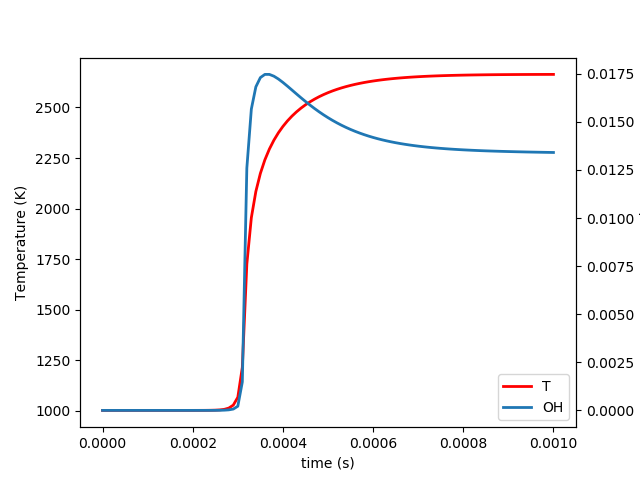

In [5]:
L1 = plt.plot(states.t, states.T, color='r', label='T', lw=2)
plt.xlabel('time (s)')
plt.ylabel('Temperature (K)')
plt.twinx()
L2 = plt.plot(states.t, states('OH').Y, label='OH', lw=2)
plt.ylabel('Mass Fraction')
_ = plt.legend(L1+L2, [line.get_label() for line in L1+L2], loc='lower right')    